# Task 3: Energy Consumption Time Series Forecasting

## Objective
Forecast short-term household energy consumption using historical time series data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
import pandas as pd

df_raw = pd.read_csv("household_power_consumption.csv", sep=';', low_memory=False)
df_raw.head()


,"Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3"
0,"16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,..."
1,"16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16"
2,"16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17"
3,"16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17"
4,"16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,..."


In [4]:
df_raw.columns


Index(['Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3'], dtype='object')

In [5]:
df_raw = pd.read_csv("household_power_consumption.csv")
df_raw.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [6]:
df_raw.columns


Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [7]:
df_raw['datetime'] = pd.to_datetime(
    df_raw['Date'] + " " + df_raw['Time'],
    dayfirst=True,
    errors='coerce'
)


In [8]:
df_raw = df_raw.replace('?', pd.NA)
df_raw = df_raw.dropna(subset=['datetime'])

df_raw['Global_active_power'] = pd.to_numeric(
    df_raw['Global_active_power'],
    errors='coerce'
)

df_raw = df_raw.dropna(subset=['Global_active_power'])

df_raw.set_index('datetime', inplace=True)


In [9]:
daily_power = (
    df_raw['Global_active_power']
    .resample('D')
    .mean()
    .reset_index()
)

daily_power.columns = ['ds', 'y']
daily_power.head()


,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


In [10]:
from prophet import Prophet

model = Prophet()
model.fit(daily_power)


C:\Users\Sybil\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22:32:50 - cmdstanpy - INFO - Chain [1] start processing
22:32:51 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
754,2009-01-08,1.122078,0.636870,1.576827
755,2009-01-09,1.212650,0.741629,1.668542
756,2009-01-10,1.421701,0.927914,1.857551
757,2009-01-11,1.437199,0.946701,1.923853
758,2009-01-12,1.153517,0.721947,1.615335


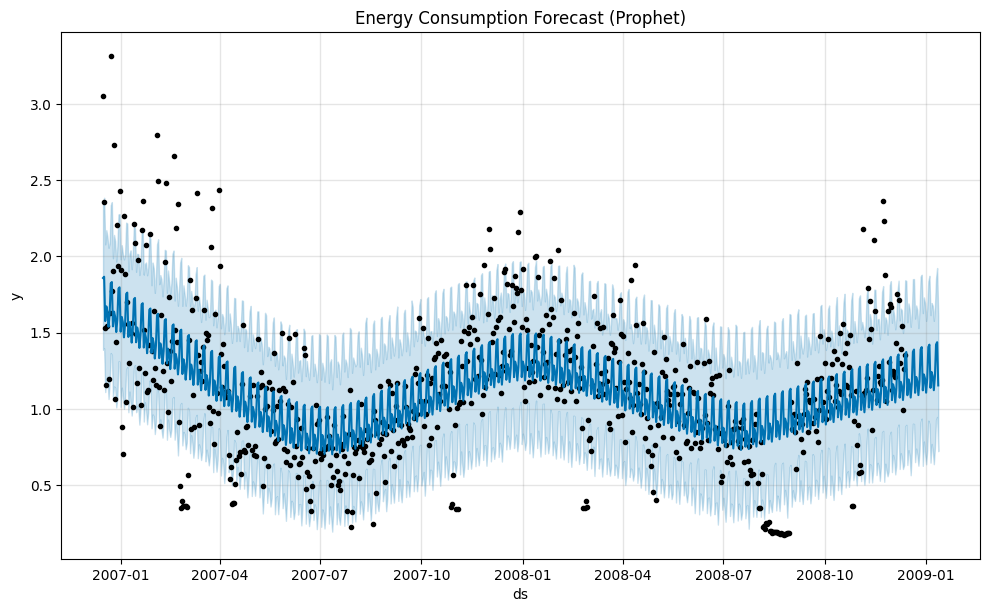

In [12]:
fig1 = model.plot(forecast)
plt.title("Energy Consumption Forecast (Prophet)")
plt.show()


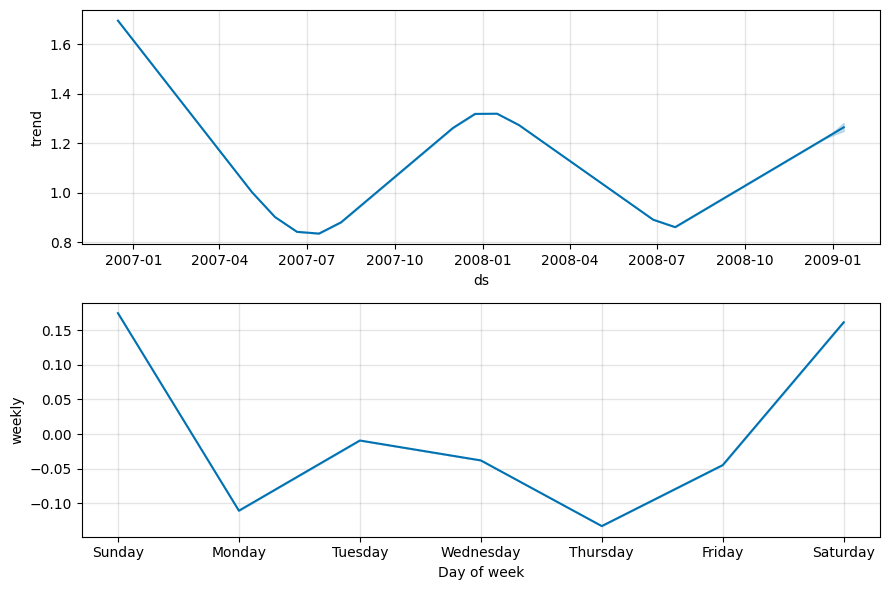

In [13]:
fig2 = model.plot_components(forecast)
plt.show()


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

actual = daily_power['y'].values
predicted = forecast.loc[:len(actual)-1, 'yhat'].values

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print("MAE:", mae)
print("RMSE:", rmse)


ValueError: Input contains NaN.

In [15]:
daily_power.isna().sum(), forecast[['yhat']].isna().sum()


(ds    0
 y     1
 dtype: int64,
 yhat    0
 dtype: int64)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred_df = forecast[['ds', 'yhat']].copy()
eval_df = daily_power.merge(pred_df, on='ds', how='inner')
eval_df = eval_df.dropna(subset=['y', 'yhat'])

mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))

print("MAE:", mae)
print("RMSE:", rmse)

eval_df.head()


MAE: 0.27228480311515457
RMSE: 0.3719437816773271


,ds,y,yhat
0,2006-12-16,3.053475,1.858282
1,2006-12-17,2.354486,1.866522
2,2006-12-18,1.530435,1.575581
3,2006-12-19,1.157079,1.672239
4,2006-12-20,1.545658,1.638459


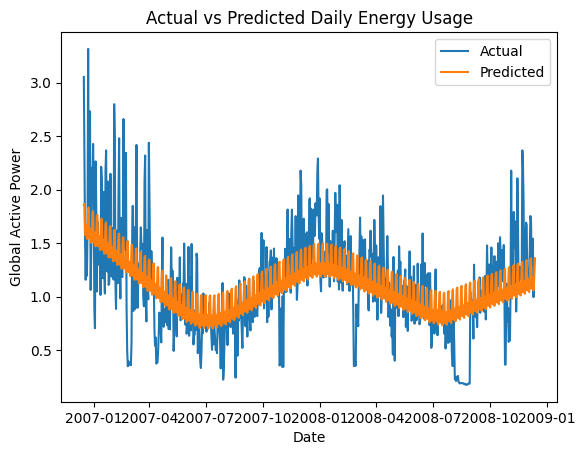

In [17]:
plt.figure()
plt.plot(eval_df['ds'], eval_df['y'], label='Actual')
plt.plot(eval_df['ds'], eval_df['yhat'], label='Predicted')
plt.title("Actual vs Predicted Daily Energy Usage")
plt.xlabel("Date")
plt.ylabel("Global Active Power")
plt.legend()
plt.show()


## Conclusion
Using the Household Power Consumption dataset, I created a daily time series of Global Active Power and trained a Prophet forecasting model. The model produced a 30-day forecast and performance was evaluated using MAE and RMSE. This approach demonstrates how time-based patterns can be used to predict short-term energy consumption.
